## Testing Various Fenics Specific Implementation Issues

There is issue with implementing full action balance code. Cartesian product doesn't allow for intergation over whole domain so it isn't clear how to assemble mass matrix:

$\int_{\Omega} \mathbf{c}N \cdot \nabla v dx$

Actually is discretized and computed in each subdomain but $\mathbf{c}$ is function of both subdomains and is not seperable:

$\int_{\Omega_1}  \int_{\Omega_2} \mathbf{c} N \cdot  \nabla v dy dx$

Now using tensor product basis for $N$ and $v$ defined as:

$N(x,y) = \sum_i \sum_k N_{ik} \phi_i(x) \beta_k(y)$ and $v = \sum_j \sum_l v_{jl} \psi_j(x) \gamma_l(y)$

Substituting this into continuous equation gives:

$\int_{\Omega_1} \int_{\Omega_2} \mathbf{c}(x,y) \sum_i \sum_k N_{ik} \phi_i(x) \beta_k(y) \cdot \nabla \sum_j \sum_l \psi_j(x) \gamma_l(y) dy dx $

Arbitrariness of test functions leads to tensor product equations:

$\sum_i \sum_k \int_{\Omega_1} \int_{\Omega_2} \mathbf{c}(x,y)  \phi_i(x) \beta_k(y) \cdot \nabla  \psi_j(x) \gamma_l(y) dy dx  N_{ik} $

Chain rule can allow for this system of equations to be expressed as a sum of some tensor products (note $\mathbf{c} = (\mathbf{c}_1,\mathbf{c}_2) )$:

$\sum_i \sum_k \int_{\Omega_1} \int_{\Omega_2} (\mathbf{c}_1(x,y)  \phi_i(x) \beta_k(y), \mathbf{c}_2(x,y)\phi_i(x) \beta_k(y)) \cdot (\gamma_l(y) \nabla_1  \psi_j(x), \psi_j(x) \nabla_2  \gamma_l(y)) dy dx  N_{ik} $

Now distributing this we obtain:

$\sum_i \sum_k \int_{\Omega_1} \int_{\Omega_2} \mathbf{c}_1(x,y)  \phi_i(x) \beta_k(y)\gamma_l(y) \cdot \nabla_1  \psi_j(x) + \mathbf{c}_2(x,y)\phi_i(x) \beta_k(y) \psi_j(x) \cdot \nabla_2  \gamma_l(y) dy dx  N_{ik} $

By Liebniz rule we can simplify, recall we can only integrate in subdomains in this case so we need to do the following. For simplicity we will just assume each subdomain is only 1 dimension but in general this is not the case and the sum will have to be written out:

$\sum_i \sum_k \left[ \int_{\Omega_1} \phi_i(x) \nabla_1 \psi_j(x) \int_{\Omega_2}  \mathbf{c}_1(x,y)  \beta_k(y)\gamma_l(y) dy dx   +  \int_{\Omega_1} \phi_i(x) \psi_j(x) \int_{\Omega_2} \mathbf{c}_2(x,y) \beta_k(y) \nabla_2  \gamma_l(y) dy dx\right]  N_{ik} $

Typically, these integrals can be evaluated as long as you have $\mathbf{c}$ at each quadrature point which we do have. However we don't have access to this in FENICS, moreover we don't want to because this would result in the matrix assembly to be far more (basically we would have to assemble a separate stiffness matrix for each degree of freedom). So how can we handle this.

For a moment let's ignore Cartesian product problem and just look at basic FEM and in 1-D, maybe instead of considering polynomial expansion of $N$ and $v$, we can consider polynomial expansion of $cN$ as so:

$N(x) = \sum_j (cN)_j \phi_j(x)$ and $v(x) = \sum_i v_i \psi_i$

Which gives following discrete system:

$\int_{\Omega} \sum_j (cN)_j \phi_j(x) \sum_i v_i \psi_{i,x} dx  $

Arbitrariness of $v$ implies the following matrix/vector product:

$\sum_j \int_{\Omega}    \phi_j(x)  \psi_{i,x} dx  (cN)_j $

Here $A = \int_{\Omega}    \phi_j(x)  \psi_{i,x} dx $  and vector $x =  (cN)_j$
Now I could just solve for $cN$ and then just divide as post processing step? This I think will work for 1D but in general will not.
what if I multiply by identity matrix (c_j/c_j) to get:

$\sum_j \int_{\Omega}    \phi_j(x)  \psi_{i,x} dx  (cN)_j = I_{c_j}\sum_j \int_{\Omega}    \phi_j(x)  \psi_{i,x} dx  (N)_j  $

Where $I_{c_j}$ is a diagonal matrix with the $j^{th}$ entry of $c$ which would be the value of $c$ at the $j^{th}$ degree of freedom

In [1]:
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Simple Example:

Let's try a diffusion type equation with Dirichlet Boundary conditions:

$ -(c(x) u_x)_x = f$

which leads to weak form:

$\int_{\Omega} c u_x v_x dx = \int_{\Omega} f v dx$ 

Now we will use method of manufactured solutions, lets let $u = exp(-x)$ and $c = x$
so we will get $f = (1-x)e^{-x}$

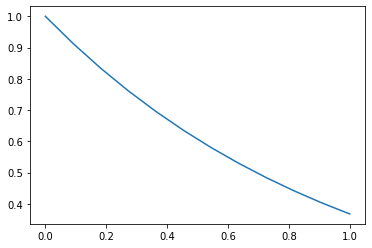

In [2]:
nx = 11
a = 0
b = 1
mesh = IntervalMesh(nx,a,b)
V1 = FunctionSpace(mesh,'P',1)
v = TestFunction(V1)
u= Function(V1)
u_trial = TrialFunction(V1)
v_test = TestFunction(V1)
dof_coordinates=V1.tabulate_dof_coordinates()
c = Expression('x[0]',domain=mesh,degree=4)
f = Expression('(1-x[0])*exp(-x[0])',domain=mesh,degree=4)

#first lets try with built in FENICS
F = c*u_trial.dx(0)*v_test.dx(0)*dx - f*v_test*dx
a,L = lhs(F),rhs(F)

def boundary(x,on_boundary):
    return on_boundary


u_D = Expression('exp(-x[0])',domain=mesh,degree=4)
bc = DirichletBC(V1, u_D, boundary)

solve(a==L,u,bc)


#A=assemble(a)
#bc.apply(A)
#b1 = assemble(L)
#bc.apply(b1)
#print(A.array())
#print(np.array(b1))

#print(u.vector()[:])
plot(u)
u_save=u

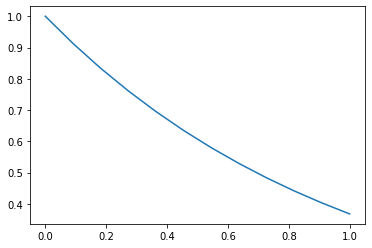

In [3]:
plot(u_D,mesh=mesh)

In [4]:
# Now try alternative strategy:
#nx = 500
#a = 0.5
#b = 1
#mesh = IntervalMesh(nx,a,b)
V1 = FunctionSpace(mesh,'P',1)
v = TestFunction(V1)
u_trial = TrialFunction(V1)
v_test = TestFunction(V1)
dof_coordinates=V1.tabulate_dof_coordinates()
#c = Expression('x[0]',domain=mesh,degree=4)
f = Expression('(1-x[0])*exp(-x[0])',domain=mesh,degree=4)

#first lets try with built in FENICS
F = u_trial.dx(0)*v_test.dx(0)*dx - f*v_test*dx
a,L = lhs(F),rhs(F)

c_dof = dof_coordinates

A = assemble(a)

b = assemble(L)

def boundary(x,on_boundary):
    return on_boundary
#if we are using cN then need to multiply in for BC
u_D = Expression('exp(-x[0])',domain=mesh,degree=4)
bc = DirichletBC(V1, u_D, boundary)
#apply bc
bc.apply(A)

bc.apply(b)

#after the fact apply c
A=np.array(A.array())
#print(A)
b=np.array(b)
#print(A.shape)
#print(c_dof)
#note, the boundary must be skipped for dirchlet BC!
#in this case I already know boundary entries so i'll fix it after fact
num_dof = len(c_dof)
for i in range(num_dof):
    A[:,i] = c_dof[i]*A[:,i]
A[0,0] = 1
A[-1,-1] = 1

#print(A)
#print(b)

u = np.linalg.solve(A,b)


#print(u)


L2 discrepancy between u with different ways of estimating c
0.175024133828


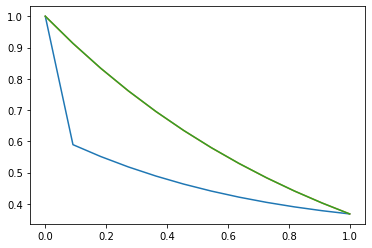

In [5]:
u_exact = Expression('exp(-x[0])',domain=mesh,degree=4)
print('L2 discrepancy between u with different ways of estimating c')
u_func = Function(V1)
u_func.vector()[:]=u
print(np.sqrt(assemble(inner(u_save-u_func,u_save-u_func)*dx)))
#print(np.sqrt(np.dot(np.absolute(u-u_save),np.absolute(u-u_save))/num_dof))
plot(u_func)
plot(u_exact, mesh=mesh)
plot(u_save)
#orang i

## Clearly there is a big problem with just picking c, if it varies alot. Even refining doesn't seem to help much, this is maybe because we have velocity of 0 at end. If i change to case where velocity isn't zero then it works out better, but still really bad. Also seems to be error that is invariant to refinement. Also solving for cN first and dividing by c does NOT work! (its same as other way it looks like) I think problem isn't consistent because rhs will change/ (I think second way I tried is wrong since it is not advection problem it is poisson so you can't just do that)

In [6]:
#alrernatively (this may only work for 1-D) we can 'average c' in a smarter way instead of just the coordinate  
# for 1 D and linear basis it makes sense to use c as average between i and jth degree of freedom

In [7]:
# Now try alternative strategy:
#nx = 500
#a = 0.5
#b = 1
#mesh = IntervalMesh(nx,a,b)
V1 = FunctionSpace(mesh,'P',1)
v = TestFunction(V1)
u_trial = TrialFunction(V1)
v_test = TestFunction(V1)
dof_coordinates=V1.tabulate_dof_coordinates()
#c = Expression('x[0]',domain=mesh,degree=4)
f = Expression('(1-x[0])*exp(-x[0])',domain=mesh,degree=4)

#first lets try with built in FENICS
F = u_trial.dx(0)*v_test.dx(0)*dx - f*v_test*dx
a,L = lhs(F),rhs(F)

c_dof = dof_coordinates

A = assemble(a)

b = assemble(L)

def boundary(x,on_boundary):
    return on_boundary

u_D = Expression('exp(-x[0])',domain=mesh,degree=4)
bc = DirichletBC(V1, u_D, boundary)
#apply bc
bc.apply(A)

bc.apply(b)

#after the fact apply c
A=np.array(A.array())
#print(A)
b=np.array(b)
#print(A.shape)
#print(c_dof)
#note, the boundary must be skipped for dirchlet BC!
#in this case I already know boundary entries so i'll fix it after fact
num_dof = len(c_dof)
for i in range(num_dof):
    for j in range(num_dof):
        A[i,j] = (c_dof[i]+c_dof[j])/2*A[i,j]
A[0,0] = 1
A[-1,-1] = 1

#print(A)
#print(b)

u = np.linalg.solve(A,b)




L2 discrepancy between u with different ways of estimating c
3.31802891794e-16


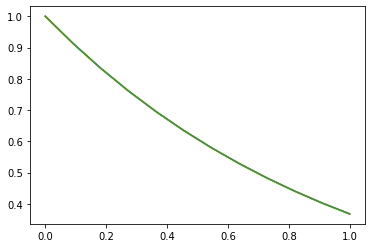

In [8]:
u_exact = Expression('exp(-x[0])',domain=mesh,degree=4)
print('L2 discrepancy between u with different ways of estimating c')
u_func = Function(V1)
u_func.vector()[:]=u
print(np.sqrt(assemble(inner(u_save-u_func,u_save-u_func)*dx)))
#print(np.sqrt(np.dot(np.absolute(u-u_save),np.absolute(u-u_save))/num_dof))
plot(u_func)
plot(u_exact, mesh=mesh)
plot(u_save)
#orang i

## This works!! Not clear how this generalizes to 2D tho unfortunately since quadrature is much mire complex.
## maybe we can get reasonable estimate with same approach but lets try:

 $ -\nabla \cdot (c(x,y) \nabla u) = f$
 
which leads to weak form:

$\int_{\Omega} c \nabla u \cdot \nabla v dx = \int_{\Omega} f v dx$ 

Now we will use method of manufactured solutions, lets let $u = exp(-x-y)$ and $c = x+y$
so we will get $f = 2*(1-x-y)e^{-x-y}$

First trying with standard FENICS

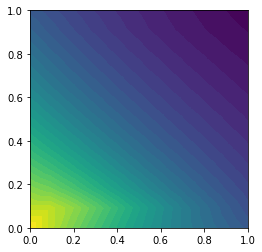

In [9]:
nx = 11
ny = 11
x0 = 0
y0 = 0
x1 = 1
y1 = 1

mesh = RectangleMesh(Point(x0,y0),Point(x1,y1),nx,ny)
V1 = FunctionSpace(mesh,'P',1)
v = TestFunction(V1)
u= Function(V1)
u_trial = TrialFunction(V1)
v_test = TestFunction(V1)
dof_coordinates=V1.tabulate_dof_coordinates()
c = Expression('x[0]+x[1]',domain=mesh,degree=4)
f = Expression('2*(1-x[0]-x[1])*exp(-x[0]-x[1])',domain=mesh,degree=4)

#first lets try with built in FENICS
F = c*u_trial.dx(0)*v_test.dx(0)*dx - f*v_test*dx
a,L = lhs(F),rhs(F)

def boundary(x,on_boundary):
    return on_boundary


u_D = Expression('exp(-x[0]-x[1])',domain=mesh,degree=4)
bc = DirichletBC(V1, u_D, boundary)

solve(a==L,u,bc)


#A=assemble(a)
#bc.apply(A)
#b1 = assemble(L)
#bc.apply(b1)
#print(A.array())
#print(np.array(b1))

#print(u.vector()[:])
plot(u)
u_save=u

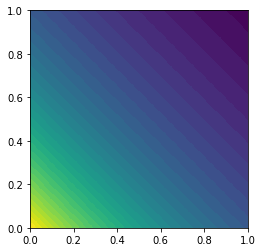

In [10]:
plot(u_D,mesh=mesh)

In [11]:
#now aproximate way:
#nx = 11
#ny = 11
#x0 = 0.2
#y0 = 0.2
#x1 = 1
#y1 = 1

#mesh = RectangleMesh(Point(x0,y0),Point(x1,y1),nx,ny)
V1 = FunctionSpace(mesh,'P',1)
v = TestFunction(V1)
u= Function(V1)
u_trial = TrialFunction(V1)
v_test = TestFunction(V1)
c = Expression('x[0]+x[1]',domain=mesh,degree=4)
f = Expression('2*(1-x[0]-x[1])*exp(-x[0]-x[1])',domain=mesh,degree=4)

#Construct weak form
F = u_trial.dx(0)*v_test.dx(0)*dx - f*v_test*dx
a,L = lhs(F),rhs(F)

def boundary(x,on_boundary):
    return on_boundary


u_D = Expression('exp(-x[0]-x[1])',domain=mesh,degree=4)
bc = DirichletBC(V1, u_D, boundary)



A=assemble(a)
bc.apply(A)
b1 = assemble(L)
bc.apply(b1)

A=np.array(A.array())
b1  = np.array(b1)
#compute c at dof
dof_coordinates=V1.tabulate_dof_coordinates()
n=V1.dim()
d=mesh.geometry().dim()
dof_coordinates.resize((n,d))
c_dof = dof_coordinates[:,0] + dof_coordinates[:,1]

num_dof = len(c_dof)
for i in range(num_dof):
    for j in range(num_dof):
        A[i,j] = (c_dof[i]+c_dof[j])/2*A[i,j]

#at boundary replace all dirichlet rows with 1
dum1=Function(V1)
u_D1 = Expression('1.0', degree=2)
bc1 = DirichletBC(V1, u_D1, boundary)
bc1.apply(dum1.vector())
boundary_dofs = np.where(dum1.vector()==1.0)[0]
for i in boundary_dofs:
    A[i,i] = 1


u = np.linalg.solve(A,b1)


L2 discrepancy between u with different ways of estimating c
3.1397793921e-16


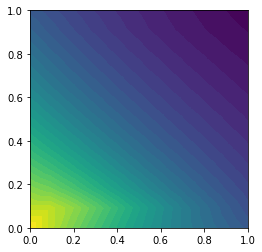

In [12]:
#u_exact = Expression('exp(-x[0])',domain=mesh,degree=4)
print('L2 discrepancy between u with different ways of estimating c')
u_func = Function(V1)
u_func.vector()[:]=u
print(np.sqrt(assemble(inner(u_save-u_func,u_save-u_func)*dx)))
#print(np.sqrt(np.dot(np.absolute(u-u_save),np.absolute(u-u_save))/num_dof))
plot(u_func)
#plot(u_exact, mesh=mesh)
#plot(u_save)
#orang i


In [16]:
#print(abs(u_func.vector()[:] - np.exp(-dof_coordinates[:,0] - dof_coordinates[:,1])))
print(max(abs(u_func.vector()[:] - np.exp(-dof_coordinates[:,0] - dof_coordinates[:,1]))))

0.102319734009


In [17]:
#now lets try cartesian product one and see if it works
nx = 11
ny = 11
x0 = 0
y0 = 0
x1 = 1
y1 = 1

mesh1 = IntervalMesh(nx,x0,x1)
mesh2 = IntervalMesh(ny,y0,y1)

V1 = FunctionSpace(mesh1, 'P', 1)
V2 = FunctionSpace(mesh2, 'P', 1)


#create trial and test functions
u1_trial = TrialFunction(V1)
v1_test = TestFunction(V1)
u2_trial = TrialFunction(V2)
v2_test = TestFunction(V2)

K11 = u1_trial.dx(0)*v1_test.dx(0)*dx
K12 = u1_trial*v1_test*dx
K21 = u2_trial.dx(0)*v2_test.dx(0)*dx
K22 = u2_trial*v2_test*dx

K11 = assemble(K11)
K12 = assemble(K12)
K21 = assemble(K21) 
K22 = assemble(K22)


F1 = v1_test*dx
F2 = v2_test*dx


F1 = assemble(F1)
F2 = assemble(F2)


#use this to mark boundary (Dirichlet) 
def boundary(x, on_boundary):
    return on_boundary

#This function is simply used to mark the boundary (not the actual boundary condition)
u_D1 = Expression('1.0', degree=2)


#establish dummy functions
dum1=Function(V1)
dum2=Function(V2)


#create boundary conditions
bc1 = DirichletBC(V1, u_D1, boundary)
bc2 = DirichletBC(V2, u_D1, boundary)

#apply to vectors to mark boundaries
bc1.apply(dum1.vector())
bc2.apply(dum2.vector())

#get index number for each boundary cooordinates in subdomain
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
boundary_dofs2 = np.where(dum2.vector()==1.0)[0]

#need all physical coordinates in case we need for calculations
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V2.tabulate_dof_coordinates()

def cartesian_product_dofs(array1,array2):
    #gives cartesian product of 2 1d vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr

def cartesian_product_coords(array1,array2):
    #gives cartesian product of 2 vectors
    dim1,n1=array1.shape
    dim2,n2=array2.shape
    out_arr=np.zeros((dim1*dim2,n1+n2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            #print(array1[a,:])
            #print(array2[b,:])
            out_arr[c,:]=np.append(array1[a,:],array2[b,:])
            c=c+1
    return out_arr

def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr

#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product_coords(dof_coordinates1,dof_coordinates2)

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
boundary_coord2 = dof_coordinates2[boundary_dofs2]

#now connect subdomain indeces to global boundary (turn this into function in future)
#maybe in future for speed we can precompute number of boundary dofs
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    cartesian_product_dofs(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1
    
last_ind = (ctr)*len(dof_coordinates2)


for j in boundary_dofs2:
    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates1),:] = \
    cartesian_product_dofs(np.arange(dof_coordinates1.shape[0]),np.array([j]))
    last_ind = last_ind+len(dof_coordinates1)    


#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)


#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)

#assemble global system using kronecker product
K11 = np.array(K11.array())
K12 = np.array(K12.array())
K21 = np.array(K21.array())
K22 = np.array(K22.array())

A = np.kron(K11,K22) + np.kron(K12,K21)

#now need to multiply by c at each dof
x = global_dof[:,0]
y = global_dof[:,1]
c_dof = x + y

num_dof = len(c_dof)
for i in range(num_dof):
    for j in range(num_dof):
        A[i,j] = (c_dof[i]+c_dof[j])/2*A[i,j]

#for dirichlet boundaries
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]

b1 = np.array(F1)
b2 = np.array(F2)
B=np.kron(b1,b2)

f_dof = 2*(1-x-y)*np.exp(-x-y)
b = f_dof*B

#set the value of solution on boundary as rhs
B[global_boundary_dofs] = np.exp(-x[global_boundary_dofs] - y[global_boundary_dofs])

#now solve
u=np.linalg.solve(A,B)

In [18]:
#evaluate errors
#print(abs(u - np.exp(-x-y)))
print(max(abs(u - np.exp(-x-y))))

0.0725041864432


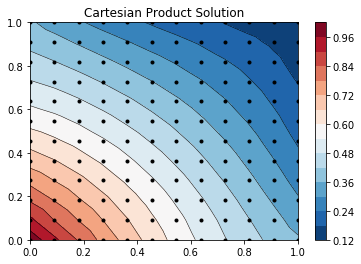

In [19]:
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('Cartesian Product Solution')

plt.subplots_adjust(hspace=0.5)
plt.show()